# Notebook 1: Data Exploration and Baseline Model
## CSE 546 Final Project - Flower Classification

**Date**: November 2024  
**Experiment**: 001 - Baseline  
**Goal**: Establish baseline performance with KNN (k=5) without preprocessing


## 1. Imports and Configuration


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('..')

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Local imports
from src.preprocessing import load_data
from src.evaluation import evaluate_model
from src.utils import RANDOM_STATE, print_class_distribution, save_results

# Set random seed for reproducibility
np.random.seed(RANDOM_STATE)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✓ All libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")


✓ All libraries imported successfully!
Random State: 42


## 2. Data Loading and Verification


In [2]:
# Load the dataset
X_train, y_train, filenames, label_mapping, class_names = load_data(data_path='../data/')

# Display basic information
print("Dataset Information:")
print("=" * 60)
print(f"Feature matrix shape: {X_train.shape}")
print(f"Number of samples: {X_train.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print("\nLabel mapping:")
print(label_mapping)


Loaded: 4065 samples, 512 features
Dataset Information:
Feature matrix shape: (4065, 512)
Number of samples: 4065
Number of features: 512
Number of classes: 5

Label mapping:
   label_id class_name
0         0      daisy
1         1  dandelion
2         2       rose
3         3  sunflower
4         4      tulip


In [3]:
# Verify data integrity
print("Data Integrity Checks:")
print("=" * 60)
print(f"Missing values in features: {X_train.isnull().sum().sum()}")
print(f"Missing values in labels: {pd.Series(y_train).isnull().sum()}")
print(f"Label range: {y_train.min()} to {y_train.max()}")
print(f"Expected classes: [0, 1, 2, 3, 4]")
print(f"Actual unique classes: {np.unique(y_train)}")
print("\n✓ Data integrity verified!")


Data Integrity Checks:
Missing values in features: 0
Missing values in labels: 0
Label range: 0 to 4
Expected classes: [0, 1, 2, 3, 4]
Actual unique classes: [0 1 2 3 4]

✓ Data integrity verified!


## 3. Class Distribution Analysis


In [4]:
# Print detailed class distribution
print_class_distribution(y_train, class_names)


Class Distribution Analysis:
Class 0 (daisy     ):  757 samples ( 18.6%)
Class 1 (dandelion ): 1045 samples ( 25.7%)
Class 2 (rose      ):  560 samples ( 13.8%)
Class 3 (sunflower ):  726 samples ( 17.9%)
Class 4 (tulip     ):  977 samples ( 24.0%)
Imbalance Ratio: 1.87 (max/min)
Most represented: dandelion (1045 samples)
Least represented: rose (560 samples)


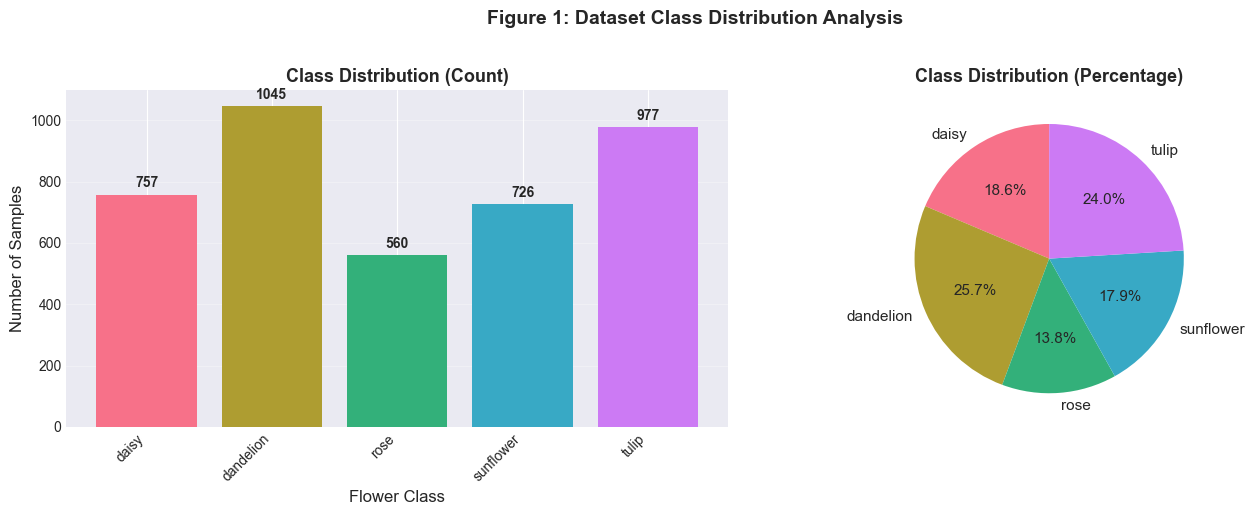

Figure saved: results/figures\report1/figure1_class_distribution.png


In [5]:
# Visualize class distribution
class_counts = pd.Series(y_train).value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(class_counts.index, class_counts.values, color=sns.color_palette("husl", 5))
axes[0].set_xticks(class_counts.index)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_xlabel('Flower Class', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Class Distribution (Count)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for idx, count in enumerate(class_counts.values):
    axes[0].text(idx, count + 15, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Pie chart
colors = sns.color_palette("husl", 5)
axes[1].pie(class_counts.values, labels=class_names, autopct='%1.1f%%', 
            startangle=90, colors=colors, textprops={'fontsize': 11})
axes[1].set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')

plt.suptitle('Figure 1: Dataset Class Distribution Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Save figure
from src.evaluation import save_figure
save_figure(fig, 'figure1_class_distribution', report_num=1)


## 4. Feature Statistics


In [6]:
# Basic feature statistics
print("Feature Statistics Summary:")
print("=" * 60)
print(X_train.describe().loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].iloc[:, :5])
print("\n(Showing first 5 features, all 512 features follow similar patterns)")

# Feature value ranges
print("\nFeature Value Ranges:")
print(f"Overall min: {X_train.min().min():.4f}")
print(f"Overall max: {X_train.max().max():.4f}")
print(f"Overall mean: {X_train.mean().mean():.4f}")
print(f"Overall std: {X_train.std().mean():.4f}")


Feature Statistics Summary:
           0       1       2       3       4
mean  0.7059  0.3937  0.6153  1.4975  0.7482
std   0.6357  0.4147  0.5602  0.9833  0.6632
min   0.0000  0.0000  0.0000  0.0000  0.0000
25%   0.2070  0.0891  0.2041  0.7475  0.2299
50%   0.5392  0.2652  0.4607  1.3031  0.5900
75%   1.0466  0.5600  0.8598  2.0726  1.1008
max   5.1513  4.1102  5.3225  6.6302  4.2029

(Showing first 5 features, all 512 features follow similar patterns)

Feature Value Ranges:
Overall min: 0.0000
Overall max: 12.5800
Overall mean: 0.7644
Overall std: 0.6736


## 5. Baseline Model Setup


In [7]:
# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

print("Cross-Validation Strategy:")
print("=" * 60)
print(f"Method: Stratified K-Fold")
print(f"Number of folds: 4")
print(f"Shuffle: True")
print(f"Random state: {RANDOM_STATE}")
print("\n✓ Cross-validation configured")


Cross-Validation Strategy:
Method: Stratified K-Fold
Number of folds: 4
Shuffle: True
Random state: 42

✓ Cross-validation configured


## 6. Experiment 001: Baseline KNN (No Preprocessing)


In [8]:
# Create baseline KNN classifier
knn_baseline = KNeighborsClassifier(n_neighbors=5)

print("Experiment 001: Baseline Model")
print("=" * 60)
print("Configuration:")
print(f"  - Classifier: K-Nearest Neighbors")
print(f"  - K (neighbors): 5")
print(f"  - Weights: uniform")
print(f"  - Metric: euclidean (default)")
print(f"  - Preprocessing: None")
print("\nRunning cross-validation...")


Experiment 001: Baseline Model
Configuration:
  - Classifier: K-Nearest Neighbors
  - K (neighbors): 5
  - Weights: uniform
  - Metric: euclidean (default)
  - Preprocessing: None

Running cross-validation...


In [9]:
# Evaluate baseline model
baseline_results, baseline_scores = evaluate_model(
    knn_baseline, X_train, y_train, cv, model_name="Baseline KNN (k=5)"
)

print("\nBaseline Results:")
print("=" * 60)
print(f"Training Accuracy:   {baseline_results['train_acc']:.4f} (±{baseline_results['train_acc_std']:.4f})")
print(f"Validation Accuracy: {baseline_results['val_acc']:.4f} (±{baseline_results['val_acc_std']:.4f})")
print(f"ROC-AUC (OvR):       {baseline_results['roc_auc']:.4f}")
print(f"F1-Score (macro):    {baseline_results['f1_macro']:.4f}")
print(f"Overfitting Gap:     {baseline_results['overfit_gap']:.4f}")



Baseline Results:
Training Accuracy:   0.9173 (±0.0011)
Validation Accuracy: 0.8716 (±0.0054)
ROC-AUC (OvR):       0.9727
F1-Score (macro):    0.8661
Overfitting Gap:     0.0458


## 7. Detailed Fold Analysis


In [10]:
# Analyze performance across folds
print("Fold-by-Fold Analysis:")
print("=" * 60)
print("\nAccuracy per fold:")
for i, acc in enumerate(baseline_scores['test_accuracy'], 1):
    print(f"  Fold {i}: {acc:.4f}")

print(f"\nConsistency Analysis:")
print(f"  Mean: {baseline_scores['test_accuracy'].mean():.4f}")
print(f"  Std:  {baseline_scores['test_accuracy'].std():.4f}")
print(f"  Min:  {baseline_scores['test_accuracy'].min():.4f}")
print(f"  Max:  {baseline_scores['test_accuracy'].max():.4f}")
print(f"  Range: {baseline_scores['test_accuracy'].max() - baseline_scores['test_accuracy'].min():.4f}")

if baseline_scores['test_accuracy'].std() < 0.02:
    print("\n✓ Good consistency across folds (std < 0.02)")
else:
    print("\n⚠ Moderate variability across folds")


Fold-by-Fold Analysis:

Accuracy per fold:
  Fold 1: 0.8653
  Fold 2: 0.8799
  Fold 3: 0.8720
  Fold 4: 0.8691

Consistency Analysis:
  Mean: 0.8716
  Std:  0.0054
  Min:  0.8653
  Max:  0.8799
  Range: 0.0146

✓ Good consistency across folds (std < 0.02)


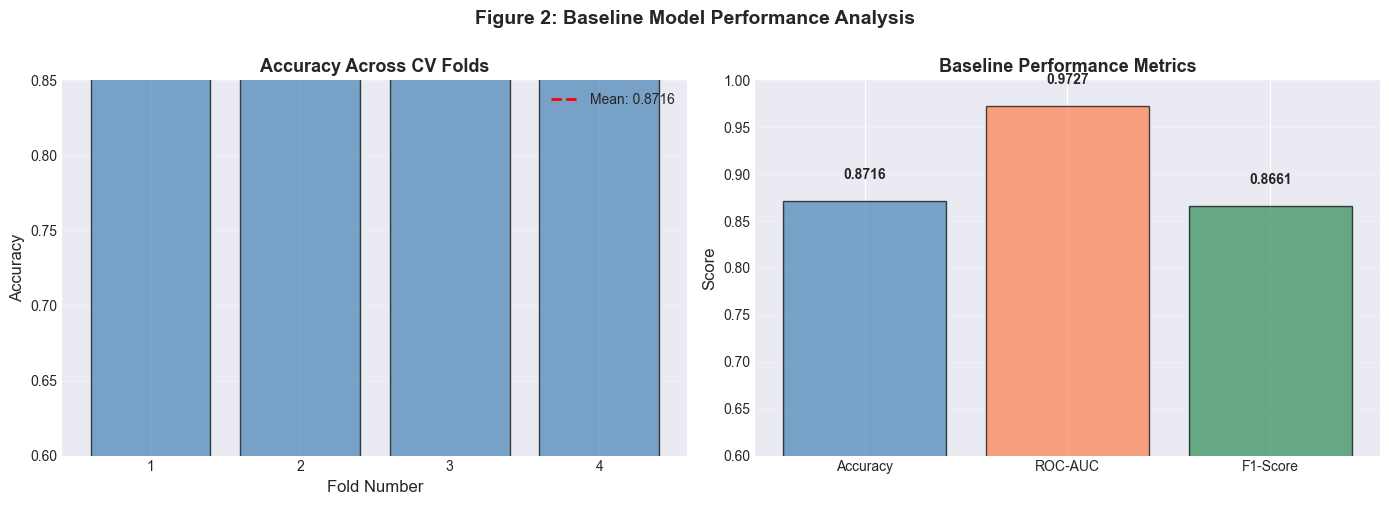

Figure saved: results/figures\report1/figure2_baseline_performance.png


In [11]:
# Visualize fold performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fold comparison
folds = np.arange(1, 5)
axes[0].bar(folds, baseline_scores['test_accuracy'], alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axhline(y=baseline_scores['test_accuracy'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Mean: {baseline_scores['test_accuracy'].mean():.4f}")
axes[0].set_xlabel('Fold Number', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Across CV Folds', fontsize=13, fontweight='bold')
axes[0].set_xticks(folds)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.6, 0.85])

# Metric comparison
metrics = ['Accuracy', 'ROC-AUC', 'F1-Score']
values = [
    baseline_results['val_acc'],
    baseline_results['roc_auc'],
    baseline_results['f1_macro']
]
axes[1].bar(metrics, values, alpha=0.7, color=['steelblue', 'coral', 'seagreen'], edgecolor='black')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Baseline Performance Metrics', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0.6, 1.0])

# Add value labels on bars
for i, v in enumerate(values):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', 
                 fontsize=10, fontweight='bold')

plt.suptitle('Figure 2: Baseline Model Performance Analysis', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

save_figure(fig, 'figure2_baseline_performance', report_num=1)


## 8. Save Results and Update Tracker


In [12]:
# Prepare results for saving
experiment_001 = {
    'experiment_id': '001',
    'description': 'Baseline KNN (k=5, no preprocessing)',
    'model': 'KNeighborsClassifier',
    'configuration': {
        'n_neighbors': 5,
        'weights': 'uniform',
        'metric': 'euclidean',
        'preprocessing': None
    },
    'cv_strategy': 'StratifiedKFold(n_splits=4, shuffle=True, random_state=42)',
    'results': baseline_results,
    'cv_scores': {
        'test_accuracy': baseline_scores['test_accuracy'].tolist(),
        'test_roc_auc_ovr': baseline_scores['test_roc_auc_ovr'].tolist(),
        'test_f1_macro': baseline_scores['test_f1_macro'].tolist()
    },
    'status': 'completed'
}

# Save results
save_results(experiment_001, 'baseline_results.pkl', results_dir='../results/preprocessing')

print("\n✓ Experiment 001 completed successfully!")
print(f"\nBaseline Performance Summary:")
print(f"  - CV Accuracy: {baseline_results['val_acc']:.4f}")
print(f"  - This establishes our baseline for improvement")
print(f"\nNext Steps:")
print(f"  1. Test normalization methods (StandardScaler, MinMaxScaler, RobustScaler)")
print(f"  2. Apply PCA with different component options")
print(f"  3. Implement feature selection methods")
print(f"  4. Optimize individual classifiers")


Results saved to: ../results/preprocessing\baseline_results.pkl

✓ Experiment 001 completed successfully!

Baseline Performance Summary:
  - CV Accuracy: 0.8716
  - This establishes our baseline for improvement

Next Steps:
  1. Test normalization methods (StandardScaler, MinMaxScaler, RobustScaler)
  2. Apply PCA with different component options
  3. Implement feature selection methods
  4. Optimize individual classifiers


In [13]:
# Log to experiment tracker
from src.utils import log_experiment

log_experiment(
    exp_num=1,
    description="Baseline KNN (k=5) without preprocessing",
    config=experiment_001['configuration'],
    results=baseline_results,
    log_file='../experiment_tracker.md'
)


Experiment 001 logged to ../experiment_tracker.md
